In [1]:
import sys
sys.path.append("../../bin")  
from models import add_hmm_layer  
import tensorflow as tf
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt

2025-01-07 10:48:48.558671: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-07 10:48:48.679986: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 10:48:49.180490: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/felix/miniforge3/envs/tiberiusdev/lib/
2025-01-07 10:48:49.180562: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinf

In [2]:
tf.__version__

'2.10.0'

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

The parallel implementation of Viterbi (`parallel_factor > 1`) is very helpful for longer sequences. Depending on the species, shorter chunks can occur. It can be more efficient to swap to the default Viterbi implementation (`parallel_factor=1`) for shorter sequences.

Idea: Set the `parallel_factor` as $$\begin{equation*}
f = \begin{cases}
1 &L < X\\
\lfloor \sqrt(L) \rfloor &\text{else}
\end{cases}
\end{equation*}$$
depending on sequence length $L$.

Problem: Find $X$.

In [4]:
# make a dummy pre-HMM model 
def make_model(hmm_factor, batch_size, in_dim=5, out_dim=15):
    input = tf.keras.layers.Input(shape=(None, in_dim) , name='main_input')
    output = tf.keras.layers.Dense(out_dim, activation="softmax", name='out')(input)
    pre_hmm_model = tf.keras.Model(inputs=input, outputs=output)
    model = add_hmm_layer(pre_hmm_model, 
                          hmm_factor=hmm_factor,
                          output_size=out_dim,
                          batch_size=batch_size,
                          share_intron_parameters=False)
    model.compile()
    return model, pre_hmm_model

In [5]:
model_1,_ = make_model(1, 32)
model_1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, None, 5)]    0           []                               
                                                                                                  
 out (Dense)                    (None, None, 15)     90          ['main_input[0][0]']             
                                                                                                  
 lstm_out (Identity)            (None, None, 15)     0           ['out[0][0]']                    
                                                                                                  
 cast (Cast)                    (None, None, 5)      0           ['main_input[0][0]']             
                                                                                            

In [6]:
def gen_seqs(batch_size, seq_len):
    # i.i.d. nucleotides witout N
    ind = np.random.randint(0, 4, size=(batch_size, seq_len))
    ind = np.eye(5)[ind].astype(np.float32)
    return ind

In [11]:
def run_experiments(batch_size):
    count_compile_time = False #whether mode compile time should be counted
    num_reps = 10 #number of repetitions for each experiment
    sqrt_lengths = list(range(2,10)) + list(range(10, 101, 10))

    df = pd.DataFrame(index=np.arange(0, len(sqrt_lengths)), 
                    columns=["L", "time_non_parallel", "time_parallel"])

    for i,sqrt_L in enumerate(sqrt_lengths):
        times = []
        for hmm_factor in [1, sqrt_L]:
            model, pre_hmm_model = make_model(hmm_factor, batch_size)
            hmm_layer = model.layers[-2]
            L = sqrt_L**2
            seqs = gen_seqs(batch_size, L)
            dummy_hmm_input = pre_hmm_model(seqs)
            if not count_compile_time:
                # make one call to compile; do not count compile time
                viterbi_seqs=hmm_layer.viterbi(dummy_hmm_input, seqs)
            start = time.time()
            for _ in range(num_reps):
                viterbi_seqs=hmm_layer.viterbi(dummy_hmm_input, seqs)
            end = time.time()
            times.append((end - start) / num_reps)
            tf.keras.backend.clear_session()
        df.loc[i] = [L] + times

    return df


def plot(df, batch_size):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    fig.suptitle(f"Batch size {batch_size}")

    # general plot
    ax1.plot(df["L"], df["time_non_parallel"], label="non-parallel")
    ax1.plot(df["L"], df["time_parallel"], label="parallel")
    ax1.set_xlabel("Sequence length")
    ax1.set_ylabel("Time (s)")
    ax1.legend()

    # plot only the small lengths
    ax2.plot(df["L"][:8], df["time_non_parallel"][:8], label="non-parallel")
    ax2.plot(df["L"][:8], df["time_parallel"][:8], label="parallel")
    ax2.legend()
        

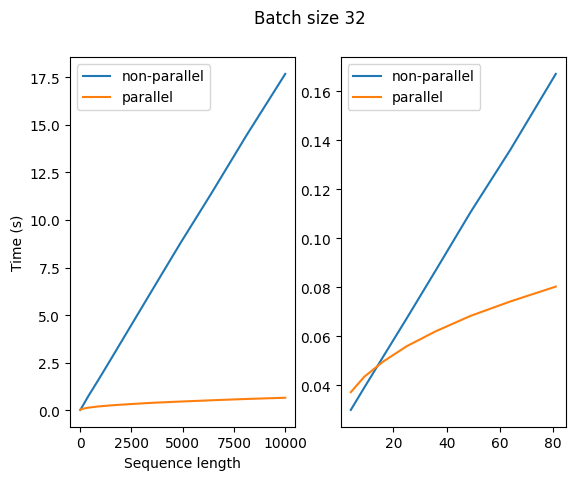

In [12]:
b = 32
df = run_experiments(b)    
plot(df, b)

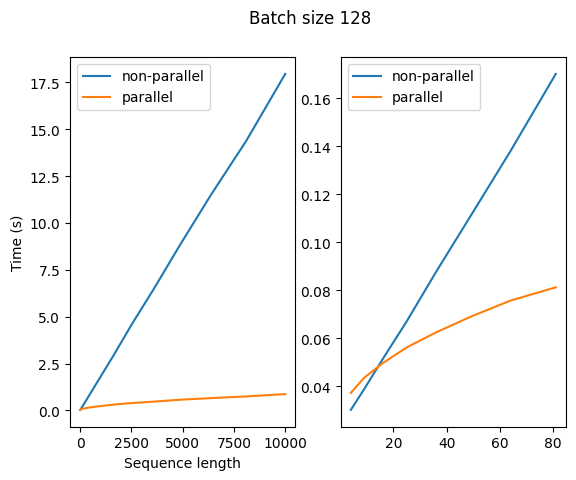

In [13]:
b = 128
df = run_experiments(b)    
plot(df, b)

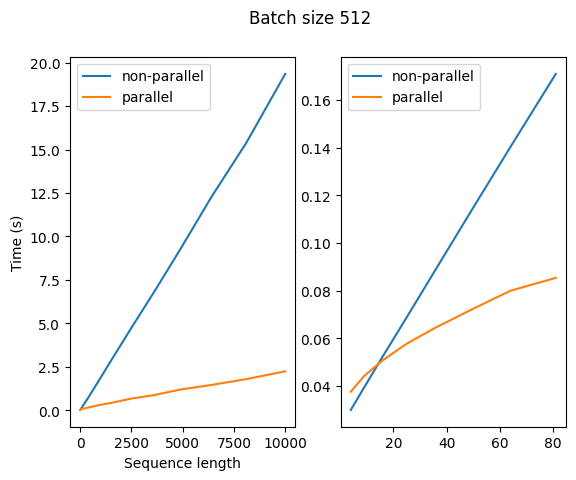

In [14]:
b = 512
df = run_experiments(b)    
plot(df, b)